<a href="https://colab.research.google.com/github/toomasliiv/DDD2424Project/blob/master/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import numpy as np
import tensorflow as tf
import tensorflow.keras.optimizers
import tensorflow.keras.losses
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print(tf.__version__)

2.2.0


## Import and check data

In [3]:
# Mount drive to access files

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Paths
train_y_path = "/content/drive/My Drive/DD2424Files/train_y.npz"
val_y_path   = "/content/drive/My Drive/DD2424Files/val_y.npz"
test_y_path  = "/content/drive/My Drive/DD2424Files/test_y.npz"

train_X_path = "/content/drive/My Drive/DD2424Files/train_X.npz"
val_X_path   = "/content/drive/My Drive/DD2424Files/val_X.npz"
test_X_path  = "/content/drive/My Drive/DD2424Files/test_X.npz"

train_X_mfcc_path = "/content/drive/My Drive/DD2424Files/train_X_mfcc.npz"
val_X_mfcc_path   = "/content/drive/My Drive/DD2424Files/val_X_mfcc.npz"
test_X_mfcc_path  = "/content/drive/My Drive/DD2424Files/test_X_mfcc.npz"

In [0]:
# Import training and validation data
train_y = np.load(train_y_path)['arr_0']
train_y = tf.one_hot(train_y, 8)

val_y = np.load(val_y_path)['arr_0']
val_y = tf.one_hot(val_y, 8)

train_X = tf.convert_to_tensor(np.expand_dims(np.load(train_X_path)['arr_0'], -1))
val_X = tf.convert_to_tensor(np.expand_dims(np.load(val_X_path)['arr_0'], -1))
#train_X_mfcc = np.load(train_X_mfcc_path)['arr_0']
#val_X_mfcc = np.load(val_X_mfcc_path)['arr_0']

In [0]:
# Check the data shape
print(train_X.shape)
print(val_X.shape)

(6397, 96, 1405, 1)
(800, 96, 1405, 1)


In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10708103227913581400, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17509985430796352467
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16780262774952405700
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3915873134385253483
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
# Assert assumptions about data

MEL_BINS   = 96
TIME_STEPS = 1405

def check_data(X, y):
  assert len(y.shape) == 2
  assert len(X.shape) == 4
  assert y.shape[0] == X.shape[0]
  assert X.shape[1] == MEL_BINS
  assert X.shape[2] == TIME_STEPS
  assert X.shape[3] == 1

check_data(val_X, val_y)
check_data(train_X, train_y)

## The model

In [0]:
# All model definitions

def get_mlp_model():

  mlp_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8)
  ])
  return mlp_model

#-------------------------------------------------------

def cnn1_model(hyperparams):
  NUMBER_FILTERS_1 = hyperparams.get("number_filters_1")
  KERNEL_SIZE = hyperparams.get("kernel_size_1")

  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(NUMBER_FILTERS_1, KERNEL_SIZE, padding = 'same', input_shape = (96, 1405, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8)                             
  ])
  return model

#-------------------------------------------------------
def cnn_k1c2_model(hyperparams):
  h = hyperparams

  model = tf.keras.models.Sequential()

  # Input layer
  model.add(tf.keras.layers.InputLayer(input_shape = (96, 1405, 1)))

  # Batch normalize
  model.add(tf.keras.layers.BatchNormalization(axis = 1))

  # Convolutional blocks
  for i in range(len(h["number_filters"])):
    NUMBER_FILTERS = h["number_filters"][i]
    KERNEL_SIZE    = h["kernel_size"][i]
    POOLING_SIZE   = h["pooling_size"][i]
    DROP_OUT_SIZE  = h["dropout"]

    model.add(tf.keras.layers.Conv2D(NUMBER_FILTERS, KERNEL_SIZE, padding = 'same'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3))
    model.add(tf.keras.layers.Activation("elu"))
    model.add(tf.keras.layers.MaxPool2D(POOLING_SIZE))
    model.add(tf.keras.layers.Dropout(DROP_OUT_SIZE))


  # Classifier block
  model.add(tf.keras.layers.Flatten())
  for el in h["hidden_layers"]:
    model.add(tf.keras.layers.Dense(el))
    model.add(tf.keras.layers.Dropout(h["drop_out_hidden"]))

  model.add(tf.keras.layers.Dense(8))

  return model


In [0]:
# Utility functions for saving outputs

def plot_history(history, val_string, loss_string):
  # Plot results
  plt.figure(1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Acc')
  plt.legend(['Accuracy', 'Validation accuracy'])
  plt.title('Accuracy')
  plt.ylim([0, 1])
  plt.savefig(val_string, dpi = 300)
  plt.close()

  plt.figure(2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Loss', 'Validation loss'])
  plt.title('Loss')
  plt.savefig(loss_string, dpi = 300)
  plt.close()

def filename():
	return str(datetime.datetime.now()).replace(':','.')[2:19]

In [0]:
# Run an experiment

def run_experiment(model, model_string, hyperparams):

  file_location = "/content/drive/My Drive/DD2424Files/Results/" + filename() + "/"
  os.mkdir(file_location)

  # Compile model

  optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparams.get("learning_rate"), epsilon=hyperparams.get("epsilon"))
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
  metrics = ['accuracy']

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

  # Train model
  BATCH_SIZE = hyperparams.get("batch_size")
  EPOCHS = hyperparams.get("epochs")
  tf.keras.backend.clear_session()

  save_callback = tf.keras.callbacks.ModelCheckpoint(
      file_location + "models_" + model_string, monitor='val_accuracy', verbose=0, save_best_only=True,
      save_weights_only=False, mode='max', save_freq='epoch')

  history = model.fit(train_X, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS,
                          validation_data=(val_X, val_y), verbose=1, callbacks = [save_callback])

  # Save stuff
  plot_history(history, file_location + "acc_" + model_string + ".png", file_location + "loss_" + model_string + ".png")
  json.dump(history.history, open(file_location + "history_" + model_string, 'w'))
  json.dump(hyperparams, open(file_location + "hyperparams_" + model_string, 'w'))

  return history




In [0]:
# Train student model

def train_student_model(student_model, teacher_models, X_train, y_train, X_val, y_val, hyperparams, model_string):
  tf.keras.backend.clear_session()
  file_location="/content/drive/My Drive/DD2424Files/Results/" + filename() + "/"
  location_name = file_location + "models_" + model_string
  metrics = ['accuracy']

  # Train model
  BATCH_SIZE = hyperparams.get("batch_size")
  EPOCHS = hyperparams.get("epochs")
  

  save_callback = tf.keras.callbacks.ModelCheckpoint(
      location_name, monitor='val_accuracy', verbose=0, save_best_only=True,
      save_weights_only=False, mode='max', save_freq='epoch')
  
  y_train = teacher_models[0].predict(X_train)

  for i in range(len(teacher_models)-1):
    y_train += teacher_models[i+1].predict(X_train)

  y_train /= len(teacher_models)

  print("shape of y_s_train: {} ".format(y_train.shape))
  student_model.compile(optimizer="adam", loss=tf.keras.losses.MSE, metrics= [tf.keras.metrics.CategoricalCrossentropy(from_logits=True), 'accuracy'])
  history = student_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val,y_val), verbose=1, callbacks = [save_callback])
  
  # Save stuff
  plot_history(history, file_location + "acc_" + model_string + ".png", file_location + "loss_" + model_string + ".png")
  json.dump(history.history, open(file_location + "history_" + model_string, 'w'))
  json.dump(hyperparams, open(file_location + "hyperparams_" + model_string, 'w'))
  
  return location_name

## Student experiments

In [0]:
# Student Experiments

# Set up teacher ensemble
m = "/models_cnn_k2c2_deep"
l = "/content/drive/My Drive/DD2424Files/Results/"

def s(time):
  return l + time + m

location_strings = [s("20-05-12 20.02.37"), 
                  s("20-05-12 19.45.54"), 
                  s("20-05-12 19.28.35"), 
                  s("20-05-12 19.05.12"), 
                  s("20-05-12 16.31.06"), 
                  s("20-05-12 18.28.17")]

teacher_models = [None, None, None, None, None]

for i in range(5):
  teacher_models[i] = tf.keras.models.load_model(location_strings[i])
'''
# 0 layer student

params = {1000000: []}
dropouts = {1000000: 0.2}

for num in [1000000]:

  hyperparams = {"number_filters" : params[num],
                "number_params" : num,
                "kernel_size" : [],
                "pooling_size" : [],
                "hidden_layers": [],
                "epsilon": 0.01, 
                "learning_rate": 0.01, 
                "batch_size": 32, 
                "epochs": 50,
                "dropout" : dropouts[num],
                "drop_out_hidden" : 0
                }

  model_string = "cnn_k2c2_0layerstudent"
  student_model = cnn_k1c2_model(hyperparams)

  locationString = train_student_model(student_model, teacher_models, train_X, train_y, val_X, val_y, hyperparams, model_string)
  print(model.summary())
  print("location: " + locationString)


# 1 layer student
params = {135000: [1], 270000: [2]}
dropouts = {135000: 0.2, 270000: 0.4}

for num in [135000, 270000]:

  hyperparams = {"number_filters" : params[num],
                "number_params" : num,
                "kernel_size" : [(3, 3)],
                "pooling_size" : [(2, 4)],
                "hidden_layers": [],
                "epsilon": 0.01, 
                "learning_rate": 0.01, 
                "batch_size": 32, 
                "epochs": 50,
                "dropout": dropouts[num],
                "drop_out_hidden": 0
                }
  
  model_string = "cnn_k2c2_1layerstudent"
  student_model = cnn_k1c2_model(hyperparams)

  locationString = train_student_model(student_model, teacher_models, train_X, train_y, val_X, val_y, hyperparams, model_string)
  print(student_model.summary())
  print("location: " + locationString)

# 4 layer student

params = {2000: [4, 6, 6, 9], 4000: [6, 10, 10, 14], 10000:[10, 16, 16, 28], 50000:
          [20, 41, 41, 63], 100000: [29, 59, 59, 90], 250000: [48, 95, 95, 142]}
dropouts = {2000: 0.1, 4000: 0.1, 10000: 0.1, 50000: 0.2, 100000: 0.2, 250000: 0.4}

for num in [2000, 4000, 10000, 50000, 100000, 250000]:

  hyperparams = {"number_filters" : params[num],
                "number_params" : num,
                "kernel_size" : [(3, 3), (3,3), (3,3), (3,3)],
                "pooling_size" : [(2,4), (2,4), (3,5), (3,5)],
                "hidden_layers": [],
                "epsilon": 0.01, 
                "learning_rate": 0.01, 
                "batch_size": 32, 
                "epochs": 50,
                "dropout": dropouts[num],
                "drop_out_hidden": 0
                }

  model_string = "cnn_k2c2_4layerstudent"
  student_model = cnn_k1c2_model(hyperparams)

  locationString = train_student_model(student_model, teacher_models, train_X, train_y, val_X, val_y, hyperparams, model_string)
  print(student_model.summary())
  print("location: " + locationString)
'''
# 5 layer student

params = params = {2000: [3, 5, 5, 8, 10], 4000: [4, 8, 8, 12, 16], 10000:[8, 12, 12, 20, 24],
                   50000:[15, 30, 30, 45, 60], 100000: [20, 41, 41, 62, 83], 250000: [33, 66, 66, 100, 133]}
dropouts = {2000: 0.1, 4000: 0.1, 10000: 0.1, 50000: 0.2, 100000: 0.2, 250000: 0.4}

for num in [250000]:

  hyperparams = {"number_filters" : params[num],
                "number_params" : num,
                "kernel_size" : [(3, 3), (3,3), (3,3), (3,3),(3,3)],
                "pooling_size" : [(2,4), (2,4), (2,4), (3,5), (4,4)],
                "hidden_layers": [],
                "epsilon": 0.01, 
                "learning_rate": 0.01, 
                "batch_size": 32, 
                "epochs": 50,
                "dropout": dropouts[num],
                "drop_out_hidden": 0
                }

  model_string = "cnn_k2c2_5layerstudent"
  student_model = cnn_k1c2_model(hyperparams)

  locationString = train_student_model(student_model, teacher_models, train_X, train_y, val_X, val_y, hyperparams, model_string)
  print(student_model.summary())
  print("location: " + locationString)

shape of y_s_train: (6397, 8) 
Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 3.9504 - categorical_crossentropy: -9.7773 - accuracy: 0.2323WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/DD2424Files/Results/20-05-14 22.05.53/models_cnn_k2c2_5layerstudent/assets
200/200 [==============================] - 23s 115ms/step - loss: 3.9504 - categorical_crossentropy: -9.7773 - accuracy: 0.2323 - val_loss: 1.3284 - val_categorical_crossentropy: 2.1578 - val_accuracy: 0.2163
Epoch 2/50
200/200 [==============================] - 22s 112ms/step - loss: 2.2842 - categorical_crossentropy: -14.7839 - accuracy: 0.357

## Student experiment 1 layer

In [0]:
# Student experiment 1 layer
# Deep k2c2

# Teacher ensamble
  
m = "/models_cnn_k2c2_deep"
l = "/content/drive/My Drive/DD2424Files/Results/"

def s(time):
  return l + time + m

location_strings = [s("20-05-12 20.02.37"), 
                  s("20-05-12 19.45.54"), 
                  s("20-05-12 19.28.35"), 
                  s("20-05-12 19.05.12"), 
                  s("20-05-12 16.31.06"), 
                  s("20-05-12 18.28.17")]

teacher_models = [None, None, None, None, None]

for i in range(5):
  teacher_models[i] = tf.keras.models.load_model(location_strings[i])

# Student model

params = {135000: [1], 270000: [2]}
dropouts = {135000: [0.2], 270000: [0.4]}

for num in [135000, 270000]:

  hyperparams = {"number_filters" : params[num],
                "number_params" : num,
                "kernel_size" : [(3, 3)],
                "pooling_size" : [(2,4)],
                "hidden_layers": [],
                "epsilon": 0.01, 
                "learning_rate": 0.01, 
                "batch_size": 32, 
                "epochs": 50,
                "dropout" : dropouts[i],
                "drop_out_hidden" : 0
                }
  
  model_string = "cnn_k2c2_1layerstudent"
  student_model = cnn_k1c2_model(hyperparams)

  model = train_student_model(student_model, teacher_models, train_X, train_y, val_X, val_y, hyperparams, model_string)
  model.summary()

##Student Experiment 2 layer

In [0]:
# Student experiment 2 layer
# Deep k2c2

# Teacher ensamble
  
m = "/models_cnn_k2c2_deep"
l = "/content/drive/My Drive/DD2424Files/Results/"

def s(time):
  return l + time + m

location_strings = [s("20-05-12 20.02.37"), 
                  s("20-05-12 19.45.54"), 
                  s("20-05-12 19.28.35"), 
                  s("20-05-12 19.05.12"), 
                  s("20-05-12 16.31.06"), 
                  s("20-05-12 18.28.17")]

teacher_models = [None, None, None, None, None]

for i in range(5):
  teacher_models[i] = tf.keras.models.load_model(location_strings[i])

# Student model
params = {17000: [1, 1], 50000: [2, 3], 100000: [3, 6], 250000: [8, 15]}
dropouts = {17000: 0.1, 50000: 0.2, 100000: 0.2, 250000: 0.4}

for num in [17000, 50000, 250000]:

  hyperparams = {"number_filters" : params[num],
                "number_params" : num,
                "kernel_size" : [(3, 3), (3,3)],
                "pooling_size" : [(2,4), (2,4)],
                "hidden_layers": [],
                "epsilon": 0.01, 
                "learning_rate": 0.01, 
                "batch_size": 32, 
                "epochs": 100,
                "dropout" : dropouts[num],
                "drop_out_hidden" : 0
                }
  
  model_string = "cnn_k2c2_2layer"
  student_model = cnn_k1c2_model(hyperparams)

  model = train_student_model(student_model, teacher_models, train_X, train_y, val_X, val_y, hyperparams, model_string)
  model.summary()



shape of y_s_train: (6397, 8) 
Epoch 1/100
200/200 [==============================] - 9s 47ms/step - loss: 3.2821 - categorical_crossentropy: -8.5894 - accuracy: 0.2310 - val_loss: 1.6654 - val_categorical_crossentropy: 1.8901 - val_accuracy: 0.2887
Epoch 2/100
200/200 [==============================] - 9s 46ms/step - loss: 2.4198 - categorical_crossentropy: -12.7186 - accuracy: 0.3645 - val_loss: 1.9953 - val_categorical_crossentropy: 1.7996 - val_accuracy: 0.3587
Epoch 3/100
199/200 [============================>.] - ETA: 0s - loss: 2.0681 - categorical_crossentropy: -13.8746 - accuracy: 0.4144

KeyboardInterrupt: ignored

## Student experiment 3 layers

In [0]:
# Student experiment 3 layer

# Teacher ensamble
  
m = "/models_cnn_k2c2_deep"
l = "/content/drive/My Drive/DD2424Files/Results/"

def s(time):
  return l + time + m

location_strings = [s("20-05-12 20.02.37"), 
                  s("20-05-12 19.45.54"), 
                  s("20-05-12 19.28.35"), 
                  s("20-05-12 19.05.12"), 
                  s("20-05-12 16.31.06"), 
                  s("20-05-12 18.28.17")]

teacher_models = [None, None, None, None, None]

for i in range(5):
  teacher_models[i] = tf.keras.models.load_model(location_strings[i])

# Student model
params = {2000: [1,1,2], 4000: [2, 3, 3], 10000:[5, 8, 8], 50000:[16, 32, 32], 100000: [27, 54, 54], 250000: [51, 101, 101]}
dropouts = {2000: 0.1, 4000: 0.1, 10000: 0.1, 50000: 0.2, 100000: 0.2, 250000: 0.4}

for num in [2000, 4000, 10000, 50000, 100000, 250000]:

  hyperparams = {"number_filters" : params[num],
                "number_params" : num,
                "kernel_size" : [(3, 3), (3,3), (3,3)],
                "pooling_size" : [(2,4), (2,4), (3,5)],
                "hidden_layers": [],
                "epsilon": 0.01, 
                "learning_rate": 0.01, 
                "batch_size": 32, 
                "epochs": 100,
                "dropout" : dropouts[num],
                "drop_out_hidden" : 0
                }


  model_string = "cnn_k2c2_3layer_student"
  student_model = cnn_k1c2_model(hyperparams)

  location_string = train_student_model(student_model, teacher_models, train_X, train_y, val_X, val_y, hyperparams, model_string)
  print(location_string)
  student_model.summary()



shape of y_s_train: (6397, 8) 
Epoch 1/100
200/200 [==============================] - 15s 73ms/step - loss: 3.9026 - categorical_crossentropy: -6.2773 - accuracy: 0.1723 - val_loss: 0.7223 - val_categorical_crossentropy: 2.0589 - val_accuracy: 0.2025
Epoch 2/100
200/200 [==============================] - 14s 70ms/step - loss: 2.9385 - categorical_crossentropy: -8.0998 - accuracy: 0.2246 - val_loss: 1.0010 - val_categorical_crossentropy: 1.9928 - val_accuracy: 0.2300
Epoch 3/100
200/200 [==============================] - 14s 70ms/step - loss: 2.6680 - categorical_crossentropy: -9.1604 - accuracy: 0.2676 - val_loss: 1.0426 - val_categorical_crossentropy: 1.9562 - val_accuracy: 0.2475
Epoch 4/100
200/200 [==============================] - 14s 71ms/step - loss: 2.5011 - categorical_crossentropy: -9.9545 - accuracy: 0.2967 - val_loss: 0.9486 - val_categorical_crossentropy: 1.9091 - val_accuracy: 0.2713
Epoch 5/100
200/200 [==============================] - 15s 73ms/step - loss: 2.3862 - cat

## Experiments

In [0]:
# Experiment 1

hyperparams = {"number_filters_1" : 15,
               "kernel_size_1" : (1, 4),
               "epsilon": 0.01, 
               "learning_rate": 0.01, 
               "batch_size": 32, 
               "epochs": 2}

model_string = "cnn15-fc8"
model = cnn1_model(hyperparams)

history = run_experiment(model, model_string, hyperparams)

15
(1, 4)
Epoch 1/2
200/200 [==============================] - 10s 51ms/step - loss: 19124.6992 - accuracy: 0.1458 - val_loss: 729.0200 - val_accuracy: 0.1737
Epoch 2/2
200/200 [==============================] - 11s 54ms/step - loss: 314.0475 - accuracy: 0.4491 - val_loss: 607.1850 - val_accuracy: 0.1825


In [0]:
# Experiment 2

hyperparams = {"number_filters" : [15, 15, 30, 30],
               "kernel_size" : [(1, 4), (1,4), (1,4), (1,4)],
               "pooling_size" : [(1,4), (1,5), (1,8), (1,8)],
               "hidden_layers": [30,30],
               "epsilon": 0.01, 
               "learning_rate": 0.01, 
               "batch_size": 32, 
               "epochs": 100,
               "dropout" : 0.4,
               "drop_out_hidden" : 0
               }

model_string = "cnn_k1c2"
model = cnn_k1c2_model(hyperparams)

history = run_experiment(model, model_string, hyperparams)
model.summary()

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 3.6970 - accuracy: 0.2795WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/DD2424Files/Results/20-05-17 09.06.11/models_cnn_k1c2/assets
200/200 [==============================] - 34s 171ms/step - loss: 3.6970 - accuracy: 0.2795 - val_loss: 1.7947 - val_accuracy: 0.3475
Epoch 2/100
200/200 [==============================] - 30s 149ms/step - loss: 1.7553 - accuracy: 0.3620 - val_loss: 1.7976 - val_accuracy: 0.3450
Epoch 3/100
200/200 [==============================] - 30s 148ms/step - loss: 1.7365 - accuracy: 0.3661 - val_loss: 1.7836 - val_accuracy: 0.3475
E

In [0]:
# Experiment 3
# Shallow k2c1

hyperparams = {"number_filters" : [43],
               "kernel_size" : [(96, 4)],
               "pooling_size" : [(96,4)],
               "hidden_layers": [12],
               "epsilon": 0.01, 
               "learning_rate": 0.01, 
               "batch_size": 32, 
               "epochs": 100,
               "dropout" : 0.0,
               "drop_out_hidden" : 0
               }


model_string = "Shallow_k2c1"
model = cnn_k1c2_model(hyperparams)

model.summary()


#history = run_experiment(model, model_string, hyperparams)
#model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_12 (Batc (None, 96, 1405, 1)       384       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 1405, 43)      16555     
_________________________________________________________________
batch_normalization_13 (Batc (None, 96, 1405, 43)      172       
_________________________________________________________________
activation_6 (Activation)    (None, 96, 1405, 43)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 351, 43)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 351, 43)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 15093)            

In [0]:
# Experiment 4
# Deep k2c1

hyperparams = {"number_filters" : [43, 43, 87, 87],
               "kernel_size" : [(96, 4), (1,4), (1,4), (1,4)],
               "pooling_size" : [(96,4), (1,4), (1,5), (1,4)],
               "hidden_layers": [70, 70],
               "epsilon": 0.01, 
               "learning_rate": 0.01, 
               "batch_size": 32, 
               "epochs": 30,
               "dropout" : 0,
               "drop_out_hidden" : 0
               }


model_string = "cnn_k1c2_deep"
model = cnn_k1c2_model(hyperparams)


history = run_experiment(model, model_string, hyperparams)
model.summary()

Epoch 1/30
200/200 [==============================] - 148s 742ms/step - loss: 1.8835 - accuracy: 0.3158 - val_loss: 2.0002 - val_accuracy: 0.2550
Epoch 2/30
200/200 [==============================] - 149s 744ms/step - loss: 1.6625 - accuracy: 0.4014 - val_loss: 2.0063 - val_accuracy: 0.3250
Epoch 3/30
200/200 [==============================] - 149s 744ms/step - loss: 1.5720 - accuracy: 0.4438 - val_loss: 1.8658 - val_accuracy: 0.3587
Epoch 4/30
200/200 [==============================] - 149s 743ms/step - loss: 1.4852 - accuracy: 0.4741 - val_loss: 2.0809 - val_accuracy: 0.3775
Epoch 5/30
200/200 [==============================] - 145s 723ms/step - loss: 1.4290 - accuracy: 0.4971 - val_loss: 2.2624 - val_accuracy: 0.2912
Epoch 6/30
200/200 [==============================] - 144s 722ms/step - loss: 1.4015 - accuracy: 0.5093 - val_loss: 2.0922 - val_accuracy: 0.3113
Epoch 7/30
200/200 [==============================] - 148s 742ms/step - loss: 1.3568 - accuracy: 0.5287 - val_loss: 1.7623 -

In [0]:
# Experiment 5
# Deep k2c2

params = {2000: [3,5,5, 8, 10],
          4000: [4, 8, 8, 12, 16],
          10000:[8, 12, 12, 20, 24],
    50000:[15, 30, 30, 45, 60],
          100000: [20, 41, 41, 62, 83],
                    250000: [33, 66, 66, 100, 133]}

num = 2000

hyperparams = {"number_filters" : params[num],
               "number_params" : num,
               "kernel_size" : [(3, 3), (3,3), (3,3), (3,3),(3,3)],
               "pooling_size" : [(2,4), (2,4), (2,4), (3,5), (4,4)],
               "hidden_layers": [],
               "epsilon": 0.01, 
               "learning_rate": 0.01, 
               "batch_size": 32, 
               "epochs": 300,
               "dropout" : 0.1,
               "drop_out_hidden" : 0
               }


model_string = "cnn_k2c2_5layer"
model = cnn_k1c2_model(hyperparams)


history = run_experiment(model, model_string, hyperparams)
model.summary()

Epoch 1/300
200/200 [==============================] - 11s 56ms/step - loss: 2.0193 - accuracy: 0.2360 - val_loss: 1.8687 - val_accuracy: 0.3375
Epoch 2/300
200/200 [==============================] - 8s 38ms/step - loss: 1.7514 - accuracy: 0.3492 - val_loss: 1.8305 - val_accuracy: 0.2988
Epoch 3/300
200/200 [==============================] - 8s 38ms/step - loss: 1.6617 - accuracy: 0.3891 - val_loss: 1.8727 - val_accuracy: 0.3313
Epoch 4/300
200/200 [==============================] - 11s 55ms/step - loss: 1.6164 - accuracy: 0.4091 - val_loss: 1.6945 - val_accuracy: 0.4075
Epoch 5/300
200/200 [==============================] - 11s 54ms/step - loss: 1.5779 - accuracy: 0.4321 - val_loss: 1.5760 - val_accuracy: 0.4375
Epoch 6/300
200/200 [==============================] - 8s 39ms/step - loss: 1.5680 - accuracy: 0.4283 - val_loss: 1.5722 - val_accuracy: 0.4325
Epoch 7/300
200/200 [==============================] - 8s 38ms/step - loss: 1.5382 - accuracy: 0.4449 - val_loss: 1.5512 - val_accura

## Training 4-layer fully convolutional neural networks

In [0]:
# Experiment 6
# Deep k2c2

params = {2000: [4,6,6,9],
          4000: [6, 10, 10, 14],
          10000:[10, 16, 16, 28],
    50000:[20, 41, 41, 63],
          100000: [29, 59, 59, 90],
                    250000: [48, 95, 95, 142]}

num = 10000
#dropouts = [0.1, 0.1, 0.1, 0.2, 0.2, 0.4]
#dropouts = [0.2, 0.4]
dropouts = [0.4]


for i, num in enumerate([250000]):

  hyperparams = {"number_filters" : params[num],
                "number_params" : num,
                "kernel_size" : [(3, 3), (3,3), (3,3), (3,3)],
                "pooling_size" : [(2,4), (2,4), (3,5), (3,5)],
                "hidden_layers": [],
                "epsilon": 0.01, 
                "learning_rate": 0.01, 
                "batch_size": 32, 
                "epochs": 50,
                "dropout" : dropouts[i],
                "drop_out_hidden" : 0
                }


  model_string = "cnn_k2c2_4layer"
  model = cnn_k1c2_model(hyperparams)


  history = run_experiment(model, model_string, hyperparams)
  model.summary()

Epoch 1/50
200/200 [==============================] - 80s 399ms/step - loss: 2.5825 - accuracy: 0.2262 - val_loss: 2.1571 - val_accuracy: 0.2688
Epoch 2/50
200/200 [==============================] - 80s 398ms/step - loss: 1.8614 - accuracy: 0.3428 - val_loss: 1.9216 - val_accuracy: 0.3350
Epoch 3/50
200/200 [==============================] - 80s 398ms/step - loss: 1.6220 - accuracy: 0.4219 - val_loss: 1.7800 - val_accuracy: 0.3738
Epoch 4/50
200/200 [==============================] - 76s 379ms/step - loss: 1.5485 - accuracy: 0.4486 - val_loss: 1.9648 - val_accuracy: 0.2950
Epoch 5/50
200/200 [==============================] - 80s 398ms/step - loss: 1.4773 - accuracy: 0.4830 - val_loss: 1.5081 - val_accuracy: 0.4650
Epoch 6/50
200/200 [==============================] - 79s 397ms/step - loss: 1.4364 - accuracy: 0.4965 - val_loss: 1.5240 - val_accuracy: 0.4688
Epoch 7/50
200/200 [==============================] - 80s 399ms/step - loss: 1.4070 - accuracy: 0.4980 - val_loss: 1.4647 - val_ac

## Training 3-layer fully convolutional neural networks

In [0]:
# Experiment 7
# Deep k2c2

params = {2000: [1,1,2],
          4000: [2, 3, 3],
          10000:[5, 8, 8],
    50000:[16, 32, 32],
          100000: [27, 54, 54],
                    250000: [51, 101, 101]}

num = 10000
dropouts = [0.1, 0.1, 0.1, 0.2, 0.2, 0.4]

for i, num in enumerate([2000, 4000, 10000, 50000, 100000, 250000]):

  hyperparams = {"number_filters" : params[num],
                "number_params" : num,
                "kernel_size" : [(3, 3), (3,3), (3,3)],
                "pooling_size" : [(2,4), (2,4), (3,5)],
                "hidden_layers": [],
                "epsilon": 0.01, 
                "learning_rate": 0.01, 
                "batch_size": 32, 
                "epochs": 100,
                "dropout" : dropouts[i],
                "drop_out_hidden" : 0
                }


  model_string = "cnn_k2c2_4layer"
  model = cnn_k1c2_model(hyperparams)


  history = run_experiment(model, model_string, hyperparams)
  model.summary()

Epoch 1/100
200/200 [==============================] - 15s 77ms/step - loss: 1.9896 - accuracy: 0.2537 - val_loss: 1.9552 - val_accuracy: 0.2875
Epoch 2/100
200/200 [==============================] - 15s 73ms/step - loss: 1.8521 - accuracy: 0.3105 - val_loss: 1.9072 - val_accuracy: 0.3150
Epoch 3/100
200/200 [==============================] - 12s 58ms/step - loss: 1.8042 - accuracy: 0.3356 - val_loss: 2.0227 - val_accuracy: 0.2212
Epoch 4/100
200/200 [==============================] - 15s 73ms/step - loss: 1.7811 - accuracy: 0.3433 - val_loss: 1.8190 - val_accuracy: 0.3388
Epoch 5/100
200/200 [==============================] - 12s 58ms/step - loss: 1.7617 - accuracy: 0.3530 - val_loss: 1.8208 - val_accuracy: 0.3363
Epoch 6/100
200/200 [==============================] - 12s 58ms/step - loss: 1.7276 - accuracy: 0.3692 - val_loss: 1.8294 - val_accuracy: 0.3212
Epoch 7/100
200/200 [==============================] - 15s 73ms/step - loss: 1.6911 - accuracy: 0.3839 - val_loss: 1.7093 - val_ac

## Train 2-level fully convolutional neural networks

In [0]:
# Experiment 8
# Deep k2c2

params = {17000:[1, 1],
    50000:[2, 3],
          100000: [3, 6],
                    250000: [8, 15]}

num = 10000
dropouts = [0.1, 0.2, 0.2, 0.4]

for i, num in enumerate([17000, 50000, 100000, 250000]):

  hyperparams = {"number_filters" : params[num],
                "number_params" : num,
                "kernel_size" : [(3, 3), (3,3)],
                "pooling_size" : [(2,4), (2,4)],
                "hidden_layers": [],
                "epsilon": 0.01, 
                "learning_rate": 0.01, 
                "batch_size": 32, 
                "epochs": 100,
                "dropout" : dropouts[i],
                "drop_out_hidden" : 0
                }


  model_string = "cnn_k2c2_2layer"
  model = cnn_k1c2_model(hyperparams)


  history = run_experiment(model, model_string, hyperparams)
  model.summary()

Epoch 1/100
200/200 [==============================] - 14s 69ms/step - loss: 2.4879 - accuracy: 0.2679 - val_loss: 1.8593 - val_accuracy: 0.2975
Epoch 2/100
200/200 [==============================] - 14s 68ms/step - loss: 1.7423 - accuracy: 0.3728 - val_loss: 1.8427 - val_accuracy: 0.3000
Epoch 3/100
200/200 [==============================] - 15s 74ms/step - loss: 1.6945 - accuracy: 0.3928 - val_loss: 1.8692 - val_accuracy: 0.3212
Epoch 4/100
200/200 [==============================] - 11s 56ms/step - loss: 1.6718 - accuracy: 0.4030 - val_loss: 1.7767 - val_accuracy: 0.3175
Epoch 5/100
200/200 [==============================] - 14s 68ms/step - loss: 1.6114 - accuracy: 0.4310 - val_loss: 1.8275 - val_accuracy: 0.3400
Epoch 6/100
200/200 [==============================] - 11s 56ms/step - loss: 1.5596 - accuracy: 0.4505 - val_loss: 1.7629 - val_accuracy: 0.3237
Epoch 7/100
200/200 [==============================] - 11s 56ms/step - loss: 1.5166 - accuracy: 0.4662 - val_loss: 1.7760 - val_ac

## Training 1-layer fully convolutional NN

In [0]:
# Experiment 9
# Deep k2c2

params = {135000:[1], 270000:[2]}

dropouts = [0.2, 0.4]

for i, num in enumerate([135000, 270000]):

  hyperparams = {"number_filters" : params[num],
                "number_params" : num,
                "kernel_size" : [(3, 3)],
                "pooling_size" : [(2,4)],
                "hidden_layers": [],
                "epsilon": 0.01, 
                "learning_rate": 0.01, 
                "batch_size": 32, 
                "epochs": 50,
                "dropout" : dropouts[i],
                "drop_out_hidden" : 0
                }


  model_string = "cnn_k2c2_1layer"
  model = cnn_k1c2_model(hyperparams)


  history = run_experiment(model, model_string, hyperparams)
  model.summary()

Epoch 1/50
200/200 [==============================] - 11s 57ms/step - loss: 6.9984 - accuracy: 0.2540 - val_loss: 1.8594 - val_accuracy: 0.3100
Epoch 2/50
200/200 [==============================] - 10s 48ms/step - loss: 1.4683 - accuracy: 0.4993 - val_loss: 1.9180 - val_accuracy: 0.2937
Epoch 3/50
200/200 [==============================] - 11s 56ms/step - loss: 1.2306 - accuracy: 0.5853 - val_loss: 1.9685 - val_accuracy: 0.3137
Epoch 4/50
200/200 [==============================] - 10s 48ms/step - loss: 0.9643 - accuracy: 0.6883 - val_loss: 2.3276 - val_accuracy: 0.2988
Epoch 5/50
200/200 [==============================] - 10s 48ms/step - loss: 0.7587 - accuracy: 0.7491 - val_loss: 2.6144 - val_accuracy: 0.2862
Epoch 6/50
200/200 [==============================] - 10s 48ms/step - loss: 0.5671 - accuracy: 0.8160 - val_loss: 2.9771 - val_accuracy: 0.2763
Epoch 7/50
200/200 [==============================] - 10s 48ms/step - loss: 0.4772 - accuracy: 0.8466 - val_loss: 3.3814 - val_accuracy:

##1' layers

In [0]:
# Experiment 11
# Deep k2c2

params = {135000:[4], 270000:[8], 540000:[16]}

dropouts = [0.2, 0.4, 0.5]

for i, num in enumerate([135000, 270000, 540000]):

  hyperparams = {"number_filters" : params[num],
                "number_params" : num,
                "kernel_size" : [(3, 3)],
                "pooling_size" : [(4,8)],
                "hidden_layers": [],
                "epsilon": 0.01, 
                "learning_rate": 0.01, 
                "batch_size": 32, 
                "epochs": 50,
                "dropout" : dropouts[i],
                "drop_out_hidden" : 0
                }


  model_string = "cnn_k2c2_1modlayer"
  model = cnn_k1c2_model(hyperparams)


  history = run_experiment(model, model_string, hyperparams)
  model.summary()

Epoch 1/50
200/200 [==============================] - 8s 41ms/step - loss: 7.9071 - accuracy: 0.2676 - val_loss: 2.9433 - val_accuracy: 0.2800
Epoch 2/50
200/200 [==============================] - 8s 42ms/step - loss: 1.9505 - accuracy: 0.4022 - val_loss: 2.0391 - val_accuracy: 0.3125
Epoch 3/50
200/200 [==============================] - 7s 33ms/step - loss: 1.4482 - accuracy: 0.5024 - val_loss: 2.0062 - val_accuracy: 0.2512
Epoch 4/50
200/200 [==============================] - 8s 41ms/step - loss: 1.3252 - accuracy: 0.5468 - val_loss: 1.9197 - val_accuracy: 0.3325
Epoch 5/50
200/200 [==============================] - 8s 41ms/step - loss: 1.2405 - accuracy: 0.5754 - val_loss: 1.7931 - val_accuracy: 0.3462
Epoch 6/50
200/200 [==============================] - 7s 34ms/step - loss: 1.0981 - accuracy: 0.6306 - val_loss: 2.1160 - val_accuracy: 0.3088
Epoch 7/50
200/200 [==============================] - 7s 33ms/step - loss: 0.9973 - accuracy: 0.6689 - val_loss: 2.1348 - val_accuracy: 0.2975

##No layer

In [0]:
# Experiment 10
# Deep k2c2

params = {1000000:[]}

dropouts = [0.2]

for i, num in enumerate([1000000]):

  hyperparams = {"number_filters" : params[num],
                "number_params" : num,
                "kernel_size" : [],
                "pooling_size" : [],
                "hidden_layers": [],
                "epsilon": 0.01, 
                "learning_rate": 0.01, 
                "batch_size": 32, 
                "epochs": 50,
                "dropout" : dropouts[i],
                "drop_out_hidden" : 0
                }


  model_string = "cnn_k2c2_0layer"
  model = cnn_k1c2_model(hyperparams)


  history = run_experiment(model, model_string, hyperparams)
  model.summary()

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 56.6382 - accuracy: 0.2634WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/DD2424Files/Results/20-05-13 22.13.00/models_cnn_k2c2_0layer/assets
200/200 [==============================] - 4s 20ms/step - loss: 56.6382 - accuracy: 0.2634 - val_loss: 11.1477 - val_accuracy: 0.2525
Epoch 2/50
200/200 [==============================] - 4s 19ms/step - loss: 1.8550 - accuracy: 0.5426 - val_loss: 2.2871 - val_accuracy: 0.2988
Epoch 3/50
200/200 [==============================] - 4s 18ms/step - loss: 1.1277 - accuracy: 0.6276 - val_loss: 2.4534 - val_accuracy: 0.3113


## Train series of shallow networks

In [0]:
# Shallow networks
# Deep k2c1



network_index = 1



hyperparams = {"number_filters" : [43, 43, 87, 87],
               "kernel_size" : [(96, 4), (1,4), (1,4), (1,4)],
               "pooling_size" : [(96,4), (1,4), (1,5), (1,4)],
               "hidden_layers": [70, 70],
               "epsilon": 0.01, 
               "learning_rate": 0.01, 
               "batch_size": 32, 
               "epochs": 60,
               "dropout" : 0,
               "drop_out_hidden" : 0
               }


model_string = "cnn_k1c2_deep"
model = cnn_k1c2_model(hyperparams)


history = run_experiment(model, model_string, hyperparams)
model.summary()

## Use test data

In [0]:
# Use test data on some models
test_X = tf.convert_to_tensor(np.expand_dims(np.load(test_X_path)['arr_0'], -1))
test_y = np.load(test_y_path)['arr_0']
test_y = tf.one_hot(test_y, 8)

In [0]:
# import model and evaluate on test data

date_and_time = "20-05-12 00.28.22"
date_and_time = "20-05-12 12.04.17"
custom_name = "cnn_k1c2"

model_location = "/content/drive/My Drive/DD2424Files/Results/" + date_and_time + "/models_" + custom_name

my_model = tf.keras.models.load_model(model_location)


my_model.evaluate(train_X, train_y)
my_model.evaluate(val_X, val_y)
my_model.evaluate(test_X, test_y)


25/25 [==============================] - 1s 20ms/step - loss: 1.5519 - accuracy: 0.4425


[1.5518596172332764, 0.4424999952316284]

## The one and only graph

In [0]:
l = "/content/drive/My Drive/DD2424Files/Results/"
test_X = tf.convert_to_tensor(np.expand_dims(np.load(test_X_path)['arr_0'], -1))
test_y = np.load(test_y_path)['arr_0']
test_y = tf.one_hot(test_y, 8)

In [0]:
# Teacher models ensamble

params = [2000, 4000, 10000, 50000, 100000, 250000]

m = "/models_cnn_k2c2_deep"
def s(time):
  return l + time + m
teacher_models = [s("20-05-12 20.02.37"), 
                  s("20-05-12 19.45.54"), 
                  s("20-05-12 19.28.35"), 
                  s("20-05-12 19.05.12"), 
                  s("20-05-12 16.31.06"), 
                  s("20-05-12 18.28.17")]

my_model = tf.keras.models.load_model(teacher_models[0])
val_logits = my_model.predict(val_X)
test_logits = my_model.predict(test_X)

for i in range(4):
  my_model = tf.keras.models.load_model(teacher_models[i+1])
  val_logits += my_model.predict(val_X)
  test_logits += my_model.predict(test_X)

val_acc = tf.keras.metrics.CategoricalAccuracy()
val_acc.update_state(val_y, val_logits)

test_acc = tf.keras.metrics.CategoricalAccuracy()
test_acc.update_state(test_y, test_logits)


print(val_acc.result().numpy())
print(test_acc.result().numpy())

0.6275
0.515


In [0]:
# 5-layer

params = [2000, 4000, 10000, 50000, 100000, 250000]

m = "/models_cnn_k2c2_deep"
def s(time):
  return l + time + m
layer5_models = [s("20-05-12 20.02.37"), 
                  s("20-05-12 19.45.54"), 
                  s("20-05-12 19.28.35"), 
                  s("20-05-12 19.05.12"), 
                  s("20-05-12 16.31.06"), 
                  s("20-05-12 18.28.17")]
layer5_accs = np.zeros(len(params))
layer5_test_accs = np.zeros(len(params))
for i, el in enumerate(layer5_models):
  my_model = tf.keras.models.load_model(el)
  layer5_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[1]
  layer5_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[1]

print(layer5_accs)
print(layer5_test_accs)




[0.5625     0.57375002 0.59750003 0.59625    0.60874999 0.61000001]


In [0]:
# 5-layer Student

params = [2000, 4000, 10000, 50000, 100000, 250000]

m = "/models_cnn_k2c2_5layerstudent"
def s(time):
  return l + time + m
layer5s_models = [s("20-05-14 20.41.54"), 
                  s("20-05-14 20.49.27"), 
                  s("20-05-14 20.57.19"), 
                  s("20-05-14 21.06.12"), 
                  s("20-05-14 21.16.56"), 
                  s("20-05-14 22.05.53")]
layer5s_accs = np.zeros(len(params))
layer5s_test_accs = np.zeros(len(params))
for i, el in enumerate(layer5s_models):
  my_model = tf.keras.models.load_model(el)
  layer5s_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[2]
  layer5s_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[2]

print(layer5s_accs)
print(layer5s_test_accs)

[0.54250002 0.54750001 0.60624999 0.62       0.63499999 0.62625003]
[0.45875001 0.45750001 0.49250001 0.495      0.50875002 0.49375001]


In [0]:
# 4-layer

layer4_params = [2000, 4000, 10000, 50000, 100000, 250000]
m = "/models_cnn_k2c2_4layer" 
def s(time):
  return l + time + m
layer4_models = [s("20-05-12 21.50.51"), 
                  s("20-05-12 22.23.42"), 
                  s("20-05-12 22.57.53"), 
                  s("20-05-13 08.48.32"),
                  s("20-05-13 14.18.47"),
                  s("20-05-13 15.40.46")]
layer4_accs = np.zeros(len(layer4_params))
layer4_test_accs = np.zeros(len(layer4_params))
for i, el in enumerate(layer4_models):
  my_model = tf.keras.models.load_model(el)
  layer4_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[1]
  layer4_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[1]

print(layer4_accs)
print(layer4_test_accs)


[0.5625     0.56999999 0.58375001 0.5675     0.57999998 0.59750003]
[0.46625    0.46125001 0.48374999 0.46000001 0.48500001 0.45249999]


In [0]:
# 4-layer Student

layer4s_params = [2000, 4000, 10000, 50000, 100000, 250000]
m = "/models_cnn_k2c2_4layerstudent" 
def s(time):
  return l + time + m
layer4s_models = [s("20-05-14 19.33.34"), 
                  s("20-05-14 19.41.08"), 
                  s("20-05-14 19.48.56"), 
                  s("20-05-14 19.57.31"),
                  s("20-05-14 20.08.46"),
                  s("20-05-14 20.22.24")]
layer4s_accs = np.zeros(len(layer4s_params))
layer4s_test_accs = np.zeros(len(layer4s_params))
for i, el in enumerate(layer4s_models):
  my_model = tf.keras.models.load_model(el)
  layer4s_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[2]
  layer4s_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[2]

print(layer4s_accs)
print(layer4s_test_accs)

[0.53625    0.59375    0.59249997 0.62       0.62625003 0.61624998]
[0.42250001 0.46000001 0.4675     0.47999999 0.49875    0.48875001]


In [0]:
# 3-layer

layer3_params = [2000, 4000, 10000, 50000, 100000, 250000]
m = "/models_cnn_k2c2_4layer" #mistake
def s(time):
  return l + time + m
layer3_models = [s("20-05-12 23.43.45"), 
                  s("20-05-13 00.04.28"), 
                  s("20-05-13 00.26.51"), 
                  s("20-05-13 00.54.11"),
                  s("20-05-13 01.39.53"),
                  s("20-05-13 02.50.07")]
layer3_accs = np.zeros(len(layer3_params))
layer3_test_accs = np.zeros(len(layer3_params))
for i, el in enumerate(layer3_models):
  my_model = tf.keras.models.load_model(el)
  layer3_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[1]
  layer3_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[1]

print(layer3_accs)
print(layer3_test_accs)


[0.44       0.47749999 0.505      0.50749999 0.50375003 0.51749998]


In [0]:
# 3-layer student

layer3s_params = [2000, 4000, 10000, 50000, 100000, 250000]
m = "/models_cnn_k2c2_3layer_student"
def s(time):
  return l + time + m
layer3s_models = [s("20-05-14 16.08.51"), 
                  s("20-05-14 16.21.43"), 
                  s("20-05-14 16.35.28"), 
                  s("20-05-14 16.50.06"),
                  s("20-05-14 17.09.35"),
                  s("20-05-14 17.33.59")]
layer3s_accs = np.zeros(len(layer3s_params))
layer3s_test_accs = np.zeros(len(layer3s_params))
for i, el in enumerate(layer3s_models):
  my_model = tf.keras.models.load_model(el)
  layer3s_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[2]
  layer3s_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[2]

print(layer3s_accs)
print(layer3s_test_accs)

[0.36875001 0.51749998 0.57499999 0.625      0.61874998 0.62124997]
[0.31874999 0.40625    0.47       0.51125002 0.49000001 0.50749999]


In [0]:
# 3-layer student 2

layer3s2_params = [2000, 2000, 4000, 10000, 50000, 100000, 250000]
m = "/models_cnn_k2c2_3layer_student"
def s(time):
  return l + time + m
layer3s2_models = [s("20-05-15 20.40.25"),
                  s("20-05-15 21.08.37"), 
                  s("20-05-15 21.28.31"), 
                  s("20-05-15 21.49.27"), 
                  s("20-05-15 22.15.58"),
                  s("20-05-15 23.00.11"),
                  s("20-05-16 00.07.14")]
layer3s2_accs = np.zeros(len(layer3s2_params))
layer3s2_test_accs = np.zeros(len(layer3s2_params))
for i, el in enumerate(layer3s2_models):
  my_model = tf.keras.models.load_model(el)
  layer3s2_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[2]
  layer3s2_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[2]

print("layer3s2_accs= " + str(layer3s2_accs))
print("layer3s2_test_accs= " + str(layer3s2_test_accs))

layer3s2_accs= [0.43000001 0.36375001 0.46000001 0.60374999 0.62875003 0.61750001
 0.61750001]
layer3s2_test_accs= [0.35374999 0.34875    0.4025     0.44999999 0.50749999 0.47874999
 0.50875002]


In [0]:
# 2-layer

layer2_params = [17000, 50000, 100000, 250000]
m = "/models_cnn_k2c2_2layer"
def s(time):
  return l + time + m
layer2_models = [s("20-05-13 05.14.59"), 
                  s("20-05-13 05.34.11"), 
                  s("20-05-13 05.54.46"), 
                  s("20-05-13 06.17.00")]
layer2_accs = np.zeros(len(layer2_params))
layer2_test_accs = np.zeros(len(layer2_params))
for i, el in enumerate(layer2_models):
  my_model = tf.keras.models.load_model(el)
  layer2_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[1]
  layer2_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[1]

print(layer2_accs)


[0.36000001 0.38124999 0.4375     0.42250001]


In [0]:
# 2-layer student

layer2s_params = [17000, 50000, 100000, 250000]
m = "/models_cnn_k2c2_2layer"
def s(time):
  return l + time + m
layer2s_models = [s("20-05-14 14.35.07"), 
                  s("20-05-14 14.47.50"), 
                  s("20-05-14 14.15.31"), 
                  s("20-05-14 15.01.01")]
layer2s_accs = np.zeros(len(layer2s_params))
layer2s_test_accs = np.zeros(len(layer2s_params))
for i, el in enumerate(layer2s_models):
  my_model = tf.keras.models.load_model(el)
  layer2s_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[2]
  layer2s_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[2]

print(layer2s_accs)
print(layer2s_test_accs)

[0.44999999 0.44624999 0.53874999 0.55000001]
[0.34875    0.38124999 0.3775     0.4025    ]


In [0]:
# 1-layer

layer1_params = [135000, 270000]
m = "/models_cnn_k2c2_2layer"
def s(time):
  return l + time + m
layer1_models = [s("20-05-13 17.02.22"), 
                  s("20-05-13 17.10.29")]
layer1_accs = np.zeros(len(layer1_params))
layer1_test_accs = np.zeros(len(layer1_params))
for i, el in enumerate(layer1_models):
  my_model = tf.keras.models.load_model(el)
  layer1_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[1]
  layer1_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[1]

print(layer1_accs)
print(layer1_test_accs)


[0.31375    0.35249999]
[0.26875001 0.30000001]


In [0]:
# 1-layer student

layer1s_params = [135000, 270000]
m = "/models_cnn_k2c2_1layerstudent"
def s(time):
  return l + time + m
layer1s_models = [s("20-05-14 19.21.55"), 
                  s("20-05-14 19.27.38")]
layer1s_accs = np.zeros(len(layer1s_params))
layer1s_test_accs = np.zeros(len(layer1s_params))
for i, el in enumerate(layer1s_models):
  my_model = tf.keras.models.load_model(el)
  layer1s_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[2]
  layer1s_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[2]

print(layer1s_accs)
print(layer1s_test_accs)

[0.33250001 0.42250001]
[0.28874999 0.30250001]


In [0]:
# 1'-layer

layer1mod_params = [135000, 270000, 1000000]
m = "/models_cnn_k2c2_1modlayer"
def s(time):
  return l + time + m
layer1mod_models = [s("20-05-13 22.56.07"), 
                  s("20-05-13 23.01.54"), s("20-05-13 23.08.09")]
layer1mod_accs = np.zeros(len(layer1mod_params))
layer1mod_test_accs = np.zeros(len(layer1mod_params))
for i, el in enumerate(layer1mod_models):
  my_model = tf.keras.models.load_model(el)
  layer1mod_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[1]
  layer1mod_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[1]

print(layer1mod_accs)
print(layer1mod_test_accs)

[0.35624999 0.4025     0.39875001]
[0.29374999 0.31625    0.32124999]


In [0]:
# 0-layer

layer0_params = [1000000]
m = "/models_cnn_k2c2_0layer"
def s(time):
  return l + time + m
layer0_models = [s("20-05-13 22.13.00")]
layer0_accs = np.zeros(len(layer0_params))
layer0_test_accs = np.zeros(len(layer0_params))
for i, el in enumerate(layer0_models):
  my_model = tf.keras.models.load_model(el)
  layer0_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[1]
  layer0_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[1]

print(layer0_accs)
print(layer0_test_accs)

[0.31125]
[0.255]


In [0]:
# 0-layer student

layer0s_params = [1000000]
m = "/models_cnn_k2c2_0layerstudent"
def s(time):
  return l + time + m
layer0s_models = [s("20-05-14 18.38.47")]
layer0s_accs = np.zeros(len(layer0s_params))
layer0s_test_accs = np.zeros(len(layer0s_params))
for i, el in enumerate(layer0s_models):
  my_model = tf.keras.models.load_model(el)
  layer0s_accs[i] = my_model.evaluate(val_X, val_y, verbose = 0)[2]
  layer0s_test_accs[i] = my_model.evaluate(test_X, test_y, verbose = 0)[2]

print(layer0s_accs)
print(layer0s_test_accs)

[0.30000001]
[0.23]


In [0]:
ensemble_accs = [0.6275]
ensemble_test_accs = [0.515]

layer5_accs = [0.5625, 0.57375002, 0.59750003, 0.59625, 0.60874999, 0.61000001]
layer5_test_accs = [0.47999999, 0.43625, 0.49000001, 0.4675, 0.50375003, 0.46250001]
layer5_params = [2000, 4000, 10000, 50000, 100000, 250000]

layer4_accs = [0.5625, 0.56999999, 0.58375001, 0.5675, 0.57999998, 0.59750003]
layer4_test_accs = [0.46625, 0.46125001, 0.48374999, 0.46000001, 0.48500001, 0.45249999]
layer4_params = [2000, 4000, 10000, 50000, 100000, 250000]

layer3_accs = [0.44, 0.47749999, 0.505, 0.50749999, 0.50375003, 0.51749998]
layer3_test_accs = [0.40000001, 0.41, 0.39125001, 0.38999999, 0.39125001, 0.41125]
layer3_params = [2000, 4000, 10000, 50000, 100000, 250000]

layer2_accs = [0.36000001, 0.38124999, 0.4375, 0.42250001]
layer2_test_accs = [0.33500001, 0.33375001, 0.33125001, 0.34]
layer2_params = [17000, 50000, 100000, 250000]

layer1_accs = [0.31375, 0.35249999]
layer1_test_accs = [0.26875001, 0.30000001]
layer1_params = [135000, 270000]

layer1mod_accs = [0.35624999, 0.4025, 0.39875001]
layer1mod_test_accs = [0.29374999, 0.31625, 0.32124999]
layer1mod_params = [135000, 270000, 1000000]

layer0_accs =  [0.31125]
layer0_test_accs = [0.255]
layer0_params = [1000000]

# Students
layer5s_accs = [0.54250002, 0.54750001, 0.60624999, 0.62, 0.63499999, 0.62625003]
layer5s_test_accs = [0.45875001, 0.45750001, 0.49250001, 0.495, 0.50875002, 0.49375001]
layer5s_params = [2000, 4000, 10000, 50000, 100000, 250000]

layer4s_accs = [0.53625, 0.59375, 0.59249997, 0.62, 0.62625003, 0.61624998]
layer4s_test_accs = [0.42250001, 0.46000001, 0.4675, 0.47999999, 0.49875, 0.48875001]
layer4s_params = [2000, 4000, 10000, 50000, 100000, 250000]

layer3s_accs = [0.36875001, 0.51749998, 0.57499999, 0.625, 0.61874998, 0.62124997]
layer3s_test_accs = [0.31874999, 0.40625, 0.47, 0.51125002, 0.49000001, 0.50749999]
layer3s_params = [2000, 4000, 10000, 50000, 100000, 250000]

layer3s2_accs= [0.43000001, 0.36375001, 0.46000001, 0.60374999, 0.62875003, 0.61750001, 0.61750001]
layer3s2_test_accs= [0.35374999, 0.34875, 0.4025, 0.44999999, 0.50749999, 0.47874999, 0.50875002]
layer3s2_params = [2000, 2000, 4000, 10000, 50000, 100000, 250000]

layer2st_accs = [0.50625002, 0.50625002, 0.50625002, 0.50625002]
layer2st_test_accs = [0.40625, 0.40625, 0.40625, 0.40625]
layer2st_params = [17000, 50000, 100000, 250000]

layer2s_accs = [0.44999999, 0.44624999, 0.53874999, 0.55000001]
layer2s_test_accs = [0.34875, 0.38124999, 0.3775, 0.4025]
layer2s_params = [17000, 50000, 100000, 250000]

layer1s_accs = [0.33250001, 0.42250001]
layer1s_test_accs = [0.28874999, 0.30250001]
layer1s_params = [135000, 270000]

layer0s_accs = [0.30000001]
layer0s_test_accs = [0.23]
layer0s_params = [1000000]

##Plot test accuracy

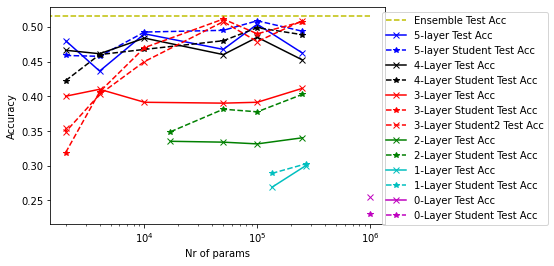

In [0]:
plt.figure(1)

plt.semilogx([0, 1000000], [ensemble_test_accs, ensemble_test_accs], '--y', label = "Ensemble Test Acc")

plt.semilogx(layer5_params, layer5_test_accs, 'x-b', label = "5-layer Test Acc")
plt.semilogx(layer5s_params, layer5s_test_accs, '*--b', label = "5-layer Student Test Acc")

plt.semilogx(layer4_params, layer4_test_accs, 'x-k', label = "4-Layer Test Acc")
plt.semilogx(layer4s_params, layer4s_test_accs, '*--k', label = "4-Layer Student Test Acc")

plt.semilogx(layer3_params, layer3_test_accs, 'x-r', label = "3-Layer Test Acc")
plt.semilogx(layer3s_params, layer3s_test_accs, '*--r', label = "3-Layer Student Test Acc")
plt.semilogx(layer3s2_params, layer3s2_test_accs, 'x--r', label = "3-Layer Student2 Test Acc")

plt.semilogx(layer2_params, layer2_test_accs, 'x-g', label = "2-Layer Test Acc")
plt.semilogx(layer2s_params, layer2s_test_accs, '*--g', label = "2-Layer Student Test Acc")
#plt.semilogx(layer2st_params[2], layer2st_test_accs[2], '*--g', label = "2-Layer Student special Test Acc")

plt.semilogx(layer1_params, layer1_test_accs, 'x-c', label = "1-Layer Test Acc")
plt.semilogx(layer1s_params, layer1s_test_accs, '*--c', label = "1-Layer Student Test Acc")
#plt.semilogx(layer1mod_params, layer1mod_test_accs, '*-y', label = "1'-Layer more filters Test Acc")

plt.semilogx(layer0_params, layer0_test_accs, 'x-m', label = "0-Layer Test Acc")
plt.semilogx(layer0s_params, layer0s_test_accs, '*--m', label = "0-Layer Student Test Acc")

plt.xlabel("Nr of params")
plt.ylabel("Accuracy")
plt.legend(loc = "upper right", bbox_to_anchor = [1.5, 1])
#plt.xlim([1000, 30000000])
plt.savefig(l+"Student_test", dpi = 300, bbox_inches = "tight")
plt.show()

## Plot validation accuracy

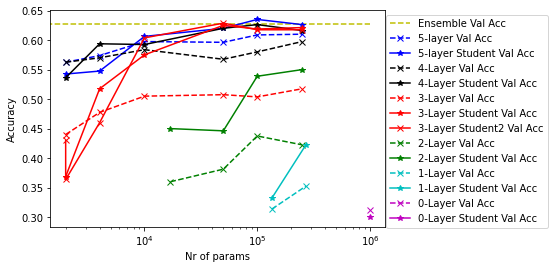

In [0]:
plt.figure(1)

plt.semilogx([0, 1000000], [ensemble_accs, ensemble_accs], '--y', label = "Ensemble Val Acc")

plt.semilogx(layer5_params, layer5_accs, 'x--b', label = "5-layer Val Acc")
plt.semilogx(layer5s_params, layer5s_accs, '*-b', label = "5-layer Student Val Acc")

plt.semilogx(layer4_params, layer4_accs, 'x--k', label = "4-Layer Val Acc")
plt.semilogx(layer4s_params, layer4s_accs, '*-k', label = "4-Layer Student Val Acc")

plt.semilogx(layer3_params, layer3_accs, 'x--r', label = "3-Layer Val Acc")
plt.semilogx(layer3s_params, layer3s_accs, '*-r', label = "3-Layer Student Val Acc")
plt.semilogx(layer3s2_params, layer3s2_accs, 'x-r', label = "3-Layer Student2 Val Acc")

plt.semilogx(layer2_params, layer2_accs, 'x--g', label = "2-Layer Val Acc")
plt.semilogx(layer2s_params, layer2s_accs, '*-g', label = "2-Layer Student Val Acc")
#plt.semilogx(layer2st_params[2], layer2st_accs[2], '*-g', label = "2-Layer Student Special Val Acc")

plt.semilogx(layer1_params, layer1_accs, 'x--c', label = "1-Layer Val Acc")
plt.semilogx(layer1s_params, layer1s_accs, '*-c', label = "1-Layer Student Val Acc")
#plt.semilogx(layer1mod_params, layer1mod_accs, '*--y', label = "1'-Layer more filters Val Acc")

plt.semilogx(layer0_params, layer0_accs, 'x--m', label = "0-Layer Val Acc")
plt.semilogx(layer0s_params, layer0s_accs, '*-m', label = "0-Layer Student Val Acc")


plt.xlabel("Nr of params")
plt.ylabel("Accuracy")
plt.legend(loc = "upper right", bbox_to_anchor = [1.5, 1])
#plt.xlim([1000, 30000000])
plt.savefig(l+"Student_val", dpi = 300, bbox_inches = "tight")
plt.show()

## k1c2, k2c1, k2c2 accuracy

In [0]:
# Use test data on some models
test_X = tf.convert_to_tensor(np.expand_dims(np.load(test_X_path)['arr_0'], -1))
test_y = np.load(test_y_path)['arr_0']
test_y = tf.one_hot(test_y, 8)

In [8]:
# k1c2

custom_name = "cnn_k1c2"
times = ["20-05-12 00.00.33", "20-05-12 12.50.16", "20-05-17 09.06.11"]
res = [None] * len(times)
for i, date_and_time in enumerate(times):
  model_location = "/content/drive/My Drive/DD2424Files/Results/" + date_and_time + "/models_" + custom_name
  my_model = tf.keras.models.load_model(model_location)
  res[i] = my_model.evaluate(test_X, test_y)[1]
print(res)

25/25 [==============================] - 1s 41ms/step - loss: 1.6160 - accuracy: 0.4350
[0.4337500035762787, 0.45500001311302185, 0.4350000023841858]


In [10]:
# k2c1

custom_name = "cnn_k1c2_deep"
times = ["20-05-17 11.01.32", "20-05-12 15.13.30", "20-05-12 15.39.49"]
res = [None] * len(times)
for i, date_and_time in enumerate(times):
  model_location = "/content/drive/My Drive/DD2424Files/Results/" + date_and_time + "/models_" + custom_name
  my_model = tf.keras.models.load_model(model_location)
  res[i] = my_model.evaluate(test_X, test_y)[1]
print(res)

25/25 [==============================] - 5s 212ms/step - loss: 1.9696 - accuracy: 0.3625
[0.41999998688697815, 0.41874998807907104, 0.36250001192092896]


In [11]:
# k2c1

custom_name = "cnn_k2c2_deep"
times = ["20-05-12 17.26.19", "20-05-12 16.31.06", "20-05-12 16.55.20"]
res = [None] * len(times)
for i, date_and_time in enumerate(times):
  model_location = "/content/drive/My Drive/DD2424Files/Results/" + date_and_time + "/models_" + custom_name
  my_model = tf.keras.models.load_model(model_location)
  res[i] = my_model.evaluate(test_X, test_y)[1]
print(res)

25/25 [==============================] - 1s 49ms/step - loss: 1.6160 - accuracy: 0.4563
[0.42750000953674316, 0.5037500262260437, 0.45625001192092896]


In [0]:
k1c2 = "cnn_k1c2"
model_location = "/content/drive/My Drive/DD2424Files/Results/" + date_and_time + "/models_" + custom_name
k1c2_00 = "20-05-12 00.00.33"
k1c2_02 = "20-05-12 12.50.16"
k1c2_04 = "20-05-17 09.06.11"

k2c1 = "k1c2_deep"
k2c1_00 = "20-05-17 11.01.32"
k2c1_02 = "20-05-12 15.13.30"
k2c1_04 = "20-05-12 15.39.49"

k2c2 = "k2c2_deep"
k2c2_00 = "20-05-12 17.26.19"
k2c2_02 = "20-05-12 16.31.06"
k2c2_04 = "20-05-12 16.55.20"

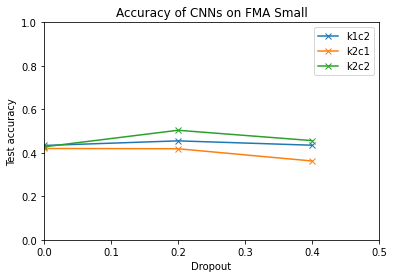

In [15]:
k1c2 = [0.4337500035762787, 0.45500001311302185, 0.4350000023841858]
k2c1 = [0.41999998688697815, 0.41874998807907104, 0.36250001192092896]
k2c2 = [0.42750000953674316, 0.5037500262260437, 0.45625001192092896]
dropouts = [0, 0.2, 0.4]

plt.figure(3973289)
plt.plot(dropouts, k1c2, '-x', label = "k1c2")
plt.plot(dropouts, k2c1, '-x', label = "k2c1")
plt.plot(dropouts, k2c2, '-x', label = "k2c2")
plt.xlabel("Dropout")
plt.ylabel("Test accuracy")
plt.ylim([0, 1])
plt.xlim([0,0.5])
plt.title("Accuracy of CNNs on FMA Small")
plt.legend()
plt.savefig("dropout.png", dpi = 300)
plt.show()